In [31]:
from utils import *
import tensorflow as tf
from keras.optimizers import Adam
from keras import utils

In [32]:
df_dict , max_rows, num_features = read_conv(train=True)
X, depression_labels, gender_labels = prep_lstm_data(df_dict, max_rows)

Removing null values present in spk_402.csv


In [33]:
# Step 3: Define and Train your LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_rows, X.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification, so use sigmoid activation
])

In [34]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, depression_labels, epochs=25, batch_size=32, validation_split=0.15, class_weight={0:1, 1:2.5})


Epoch 1/25
3/3 [==============================] - 1s 149ms/step - loss: 1.0071 - accuracy: 0.3973 - val_loss: 0.6917 - val_accuracy: 0.8571
Epoch 2/25
3/3 [==============================] - 0s 68ms/step - loss: 1.0020 - accuracy: 0.5753 - val_loss: 0.6939 - val_accuracy: 0.1429
Epoch 3/25
3/3 [==============================] - 0s 68ms/step - loss: 1.0159 - accuracy: 0.4247 - val_loss: 0.7286 - val_accuracy: 0.1429
Epoch 4/25
3/3 [==============================] - 0s 67ms/step - loss: 1.0506 - accuracy: 0.4110 - val_loss: 0.6981 - val_accuracy: 0.1429
Epoch 5/25
3/3 [==============================] - 0s 68ms/step - loss: 0.9948 - accuracy: 0.5205 - val_loss: 0.7295 - val_accuracy: 0.1429
Epoch 6/25
3/3 [==============================] - 0s 68ms/step - loss: 1.0007 - accuracy: 0.3562 - val_loss: 0.7519 - val_accuracy: 0.1429
Epoch 7/25
3/3 [==============================] - 0s 69ms/step - loss: 0.9935 - accuracy: 0.3288 - val_loss: 0.7628 - val_accuracy: 0.1429
Epoch 8/25
3/3 [==========

In [35]:
test_df_dict , _, _ = read_conv(train=False)
test_features, test_depression_labels, test_gender_labels = prep_lstm_data(test_df_dict, max_rows)

In [36]:
test_loss, test_accuracy = model.evaluate(test_features, test_depression_labels)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 25ms/step - loss: 0.7469 - accuracy: 0.3000
Test Accuracy: 0.30000001192092896


In [37]:
PATH_TEST = "../processed_data/cleaned_data/clean_test_data.csv"
test_df = pd.read_csv(PATH_TEST)
y_test = test_df[["Participant_ID", "Depression", "Gender"]]
y_test = y_test.groupby("Participant_ID").agg({"Depression":"max", "Gender":"max"}).reset_index()
y_test.head()

,Participant_ID,Depression,Gender
0,305,0,1
1,312,0,1
2,315,0,1
3,320,1,0
4,321,1,0


In [38]:
y_test["Depression_predicted"] = model.predict(test_features)

1/1 [==============================] - 0s 158ms/step


In [39]:
y_test['Depression_predicted'] = np.where(y_test['Depression_predicted']>=0.5, 1, 0)

Recall Male: 1.0
Recall Female: 1.0
Accuracy: 0.3
Balanced Accuracy: 0.5
Equality of Opportunity: 1.0


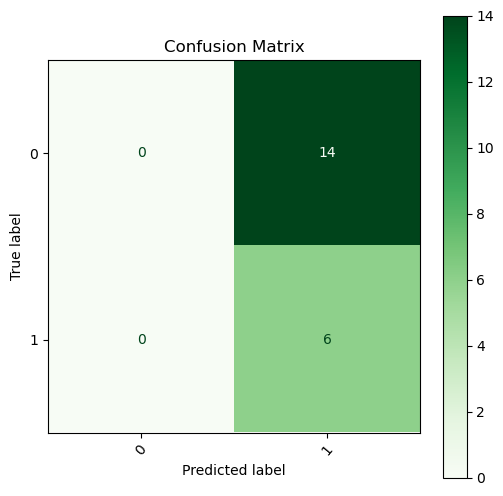

In [40]:
# Aggregate target and predicted labels at participant level for male participants
y_male = y_test[y_test['Gender'] == 1]
# Aggregate target and predicted labels at participant level for female participants
y_female = y_test[y_test['Gender'] == 0]
# Compute recall/tpr for male and female classification
tpr_male = recall_score(y_male['Depression'], y_male['Depression_predicted'])
tpr_female = recall_score(y_female['Depression'], y_female['Depression_predicted'])

# Compute metrics
accuracy = accuracy_score(y_test['Depression'], y_test['Depression_predicted'])
bal_accuracy = balanced_accuracy_score(y_test['Depression'], y_test['Depression_predicted'])

# Compute Equality of opportunity score
print("Recall Male:", tpr_male)
print("Recall Female:", tpr_female)
print(f"Accuracy: {accuracy}")
print(f"Balanced Accuracy: {bal_accuracy}")
print(f"Equality of Opportunity: {1-abs(tpr_male-tpr_female)}")
conf_matrix = confusion_matrix(y_test['Depression'], y_test['Depression_predicted'])
#Visualizing the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()